# Segmentation with star noise

This notebook explores the abilities of the model to also remove star noise. This is the situation where a star also trigger pixels.

In [68]:
# Importing some libraries

# Torch 
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# Other libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt

**Unpacking the data**

In this first part, some functions are defined to unpack the data.

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    # to avoid errors that occur when loading pickle files on cpu that were originally saved using a gpu
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
# Function that enables you to unpack a certain chunk of data
def load_chunk_file(file_path, chunk_i):
    with open(file_path+f'chunk_{chunk_i}', 'rb') as file:
            loaded_data = CPU_Unpickler(file).load()
            
    return loaded_data

In [4]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    mask_gamma_ray = np.array((data_noisy_all[1]==1))
    data_noisy_chunk = np.array(data_noisy_all[0])[mask_gamma_ray]
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])[mask_gamma_ray]
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
# Get it in the right shape
data_noisy_bg = data_noisy_tot.reshape(64*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(64*chunk_tot, 56, 56)


**Function star**

In [14]:
def star_noise(mean, std):
    chunk_tot = 100
    data_star = np.zeros((64*chunk_tot, 56, 56))
    loc_random_x = np.random.randint(1, high=54, size=64*chunk_tot, dtype=int)
    loc_random_y = np.random.randint(1, high=54, size=64*chunk_tot, dtype=int)
    indices = np.arange(64 * chunk_tot)
    
    for x_i in range(0,3):
        for y_i in range(0,3):
            data_star[indices, loc_random_x+x_i, loc_random_y+y_i] = np.random.normal(loc=20, scale=1, size=(64*chunk_tot))
    
    return data_star

**Data Preperation**

In [15]:
nan_mask = np.isnan(data_noisy_bg[0])
data_star = star_noise(100, 5)*(~nan_mask)

#data_noisy = data_noisy_bg + data_star
print(np.sum(np.sum(data_star, axis=(1,2))>0))

4460


In [28]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

data_noisy_nonan = np.nan_to_num(data_noisy_bg)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy_bg, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification


threshold = 0

data_true_binary = np.zeros((64*chunk_tot, 56, 56))
data_true_binary[data_true>threshold] = 1
data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy_bg[images_high_mask]
data_noisy_tensor = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_true_tensor = (torch.from_numpy(data_true_binary_flat[images_high_mask])).float()

data_noisy_train_bg = data_noisy_tensor[:idx_split]
data_noisy_test_bg = data_noisy_tensor[idx_split:]

#data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_true_train = data_true_tensor[:idx_split]
data_true_test = data_true_tensor[idx_split:]


In [29]:
def add_noise(star_mean):
    data_star = star_noise(star_mean, star_mean/20)*(~nan_mask)
    data_star_tensor = (torch.from_numpy((data_star)[images_high_mask])).float()
    
    data_star_train = data_star_tensor[:idx_split]
    data_star_test = data_star_tensor[idx_split:]
    
    data_noisy_train = data_noisy_train_bg + data_star_train
    data_noisy_test = data_noisy_test_bg + data_star_test
    
    #data_noisy_train_im = data_noisy_train
    #data_noisy_test_im = data_noisy_test
    
    return data_star_train, data_star_test, data_noisy_train, data_noisy_test #, data_noisy_train_im, data_noisy_test_im




In [30]:
def add_noise(star_mean):
    threshold = 0
    data_true_binary = np.zeros((64*chunk_tot, 56, 56))
    data_true_binary[data_true>threshold] = 1
    data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))
    
    # Putting them to the right form with normalization
    data_noisy_arr_bg = data_noisy_bg[images_high_mask]
    data_noisy_tensor_bg = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
    data_true_tensor = (torch.from_numpy(data_true_binary_flat[images_high_mask])).float()
    
    # Split train and test

    N, w, h = data_noisy_tensor_bg.shape
    idx_split = int(N*0.8) # 80% training, 20% testing
    
    data_star = star_noise(star_mean, star_mean/20)*(~nan_mask)
    data_star_tensor = (torch.from_numpy((data_star)[images_high_mask])).float()    

    data_star_train = data_star_tensor[:idx_split]
    data_star_test = data_star_tensor[idx_split:]

    data_noisy_train = data_noisy_tensor_bg[:idx_split]+data_star_train
    data_true_train = data_true_tensor[:idx_split]
    data_noisy_test = data_noisy_tensor_bg[idx_split:]+data_star_test
    data_true_test = data_true_tensor[idx_split:]

    #data_noisy_train_im = data_noisy_tensor_im[:idx_split]
    #data_true_train_im = data_true_tensor_im[:idx_split]
    #data_noisy_test_im = data_noisy_tensor_im[idx_split:]
    data_true_test_im = data_true_tensor_im[idx_split:]
    
    return data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_star_train, data_star_test, idx_split, data_true_test_im




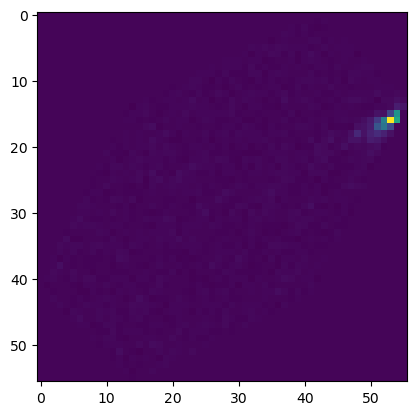

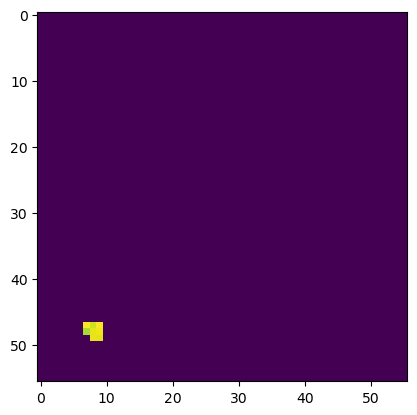

In [31]:
data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_star_train, data_star_test, idx_split, data_true_test_im = add_noise(20)

plt.figure()
plt.imshow(data_noisy_train_bg[2])
plt.show()

plt.figure()
plt.imshow(data_star_train[2])
plt.show()

In [32]:
# Batch form
batch_size = 1

N, H, W = data_noisy_train.shape
N_new = N//batch_size

data_noisy_train_batch = data_noisy_train[:int(N_new*batch_size)].reshape(N_new, batch_size, 1, H, W)
data_true_train_batch = data_true_train[:int(N_new*batch_size)].reshape(N_new, batch_size, H*W)

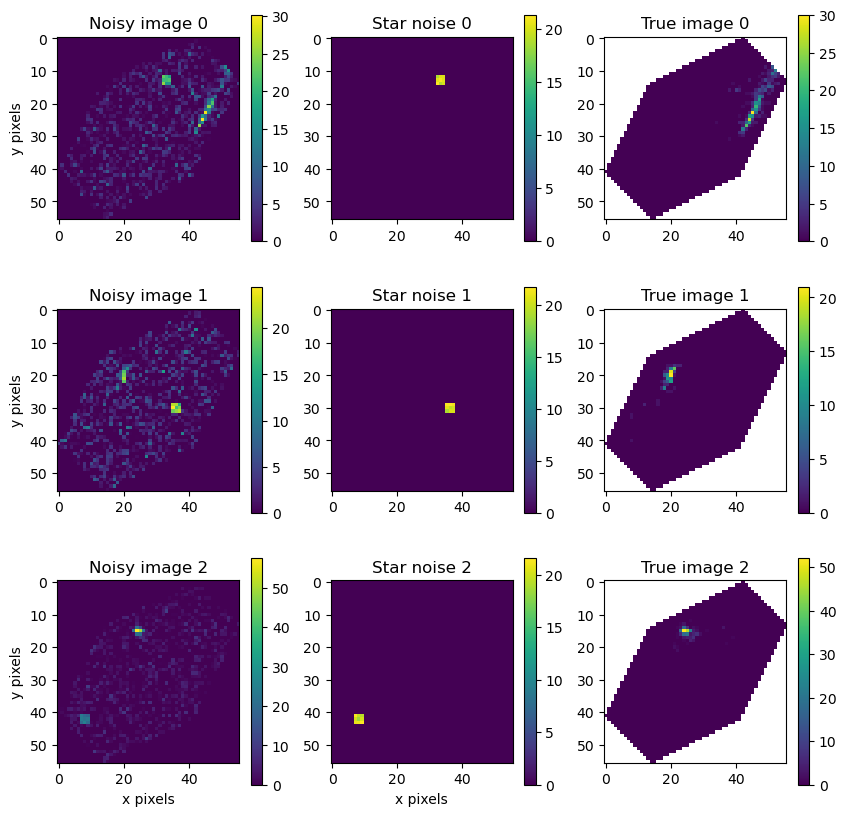

In [85]:
data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_star_train, data_star_test, idx_split, data_true_test_im = add_noise(20)

n_start = 6
n_images = 3 # Compare 3 examples

fig, axs = plt.subplots(n_images, 3, figsize=(10,10))

for i in range(0,n_images):
    vmax = np.nanmax(data_noisy_test[i])
    
    im_noisy = axs[i,0].imshow(data_noisy_test[i], vmin=0)#, vmax=vmax*1.1)
    axs[i,0].set_title(f"Noisy image {i}")
    axs[i,0].set_ylabel("y pixels")
    plt.colorbar(im_noisy, ax=axs[i,0])
    
    im_true = axs[i,1].imshow(data_star_test[i], vmin=0)#, vmax=vmax*1.1)
    axs[i,1].set_title(f"Star noise {i}")
    plt.colorbar(im_true, ax=axs[i,1])    
    
    im_true = axs[i,2].imshow(data_true_test_im[i], vmin=0)#, vmax=vmax*1.1)
    axs[i,2].set_title(f"True image {i}")
    plt.colorbar(im_true, ax=axs[i,2])
    
    
axs[i,0].set_xlabel("x pixels")
axs[i,1].set_xlabel("x pixels")


plt.show()

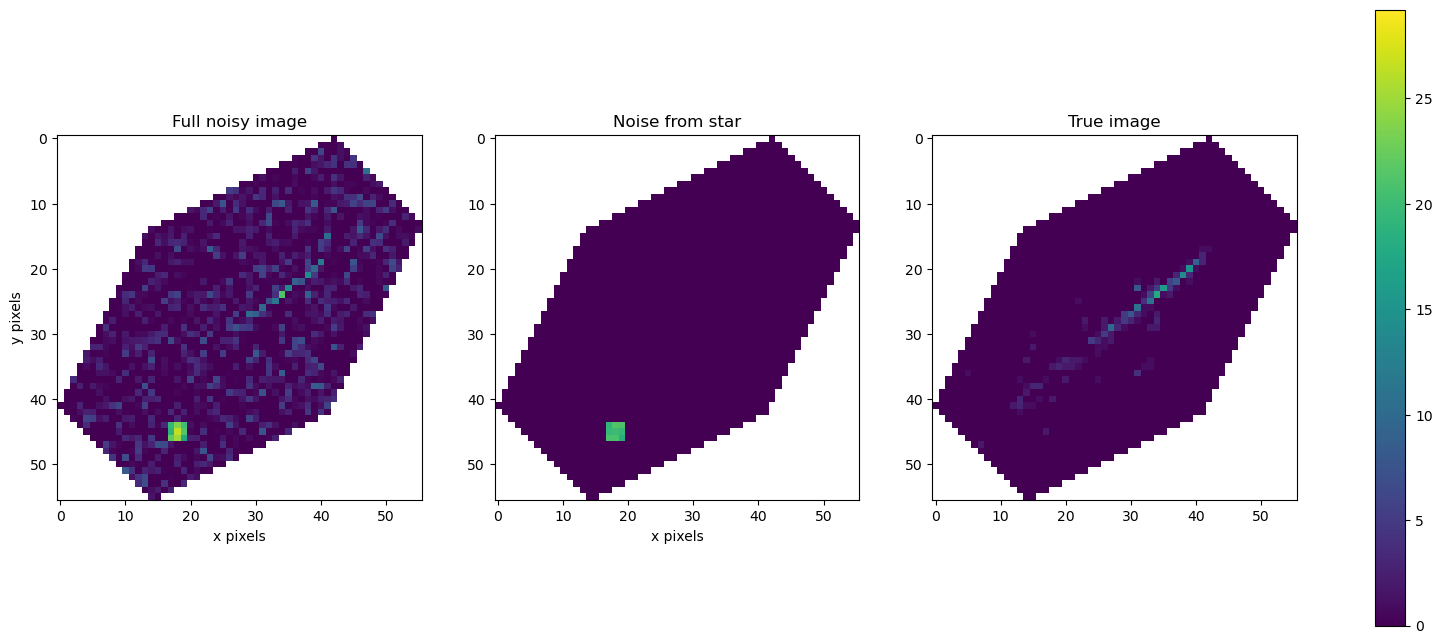

In [52]:
n_start = 6
n_images = 3 # Compare 3 examples

i=5

fig_star_ex, axs = plt.subplots(1, 3, figsize=(20,8))

vmax = np.nanmax(data_noisy_test[i])

image_1 = data_noisy_test[i]
image_1[nan_mask] = np.nan
im_noisy = axs[0].imshow(image_1, vmin=0, vmax=vmax*1.1)
axs[0].set_title(f"Full noisy image")
axs[0].set_ylabel("y pixels")
#plt.colorbar(im_noisy, ax=axs[0])

image_2 = data_star_test[i]
image_2[nan_mask] = np.nan
im_true = axs[1].imshow(data_star_test[i], vmin=0, vmax=vmax*1.1)
axs[1].set_title(f"Noise from star")
#plt.colorbar(im_true, ax=axs[1])    
    
im_true = axs[2].imshow(data_true_test_im[i], vmin=0, vmax=vmax*1.1)
axs[2].set_title(f"True image")
#plt.colorbar(im_true, ax=axs[2])
    
    
axs[0].set_xlabel("x pixels")
axs[1].set_xlabel("x pixels")

fig.colorbar(im_true, ax=axs.ravel().tolist())


plt.show()

fig_star_ex.savefig("images/StarExample.pdf")

**The Autoencoder Model**

In [53]:
# AE with 4 layers

class AE4(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(2, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

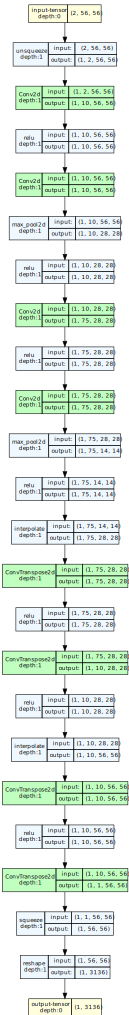

In [54]:
# Visualize the model
model_graph = draw_graph(AE4(), input_size=(2,56,56), expand_nested=True)
model_graph.visual_graph

In [55]:
print("Number of parameters:")
print(sum(p.numel() for p in AE4().parameters() if p.requires_grad))

Number of parameters:
117086


In [56]:
learning_rate = 0.0005

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

In [57]:
# Function to calculate the intersection-over-union
def IOU_calc(clean_iou, true_iou): 
    clean_sum = torch.sum(clean_iou)
    true_sum = torch.sum(true_iou)
    true_iou2 = torch.zeros(true_iou.shape)
    
    true_iou2[true_iou==0] = 2 
    true_iou2[true_iou==1] = 1
    
    intersection_arr = (clean_iou==true_iou2)
    intersection_sum = torch.sum(intersection_arr)
    
    IOU = intersection_sum/(clean_sum+true_sum-intersection_sum)
    
    return IOU

In [59]:
# Functions and definitions for 
n_epochs = 3

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

weight = 2

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    data_star_train_clone = torch.clone(data_star_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    data_star_train[random_indices] = data_star_train_clone
    
    for noisy_bg, star, true in zip(data_noisy_train, data_star_train, data_true_train):
        noisy = np.zeros((2,56,56))
        noisy[0,:,:] = noisy_bg
        noisy[1,:,:] = star
        noisy = torch.from_numpy(noisy).float()
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy_bg, star, true in zip(data_noisy_test, data_star_test, data_true_test):
            #print(noisy_bg.shape)
            noisy = np.zeros((2,56,56))
            noisy[0,:,:] = noisy_bg
            noisy[1,:,:] = star
            noisy = torch.from_numpy(noisy).float()
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
            test_loss += loss.item()
            output_data = F.sigmoid(output.data)
            output_binary = output_data.round()
            pred = output.data.max(1, keepdim=True)[1]
            IOU += IOU_calc(output_binary, true)
    
    test_loss /= len(data_noisy_test)
    IOU /= len(data_noisy_test)
    test_losses.append(test_loss)
    IOU_list.append(IOU)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
    print(f'IOU: {IOU}')

In [61]:
%%time

n_epochs = 15

learning_rate = 0.0005

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

#data_star_train, data_star_test, data_noisy_train, data_noisy_test, data_noisy_train_im, data_noisy_test_im = add_noise(20)
data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_star_train, data_star_test, idx_split, data_true_test_im = add_noise(20)


test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.8368
IOU: 0.025427505373954773
Training set: Avg. loss: 0.1242

Test set: Avg. loss: 0.0957
IOU: 0.4055909514427185
Training set: Avg. loss: 0.1009

Test set: Avg. loss: 0.0826
IOU: 0.4407152235507965
Training set: Avg. loss: 0.0938

Test set: Avg. loss: 0.0756
IOU: 0.47084280848503113
Training set: Avg. loss: 0.0886

Test set: Avg. loss: 0.0747
IOU: 0.4851897060871124
Training set: Avg. loss: 0.0863

Test set: Avg. loss: 0.0769
IOU: 0.4687579870223999
Training set: Avg. loss: 0.0842

Test set: Avg. loss: 0.0719
IOU: 0.48862776160240173
Training set: Avg. loss: 0.0826

Test set: Avg. loss: 0.0717
IOU: 0.4887053668498993
Training set: Avg. loss: 0.0818

Test set: Avg. loss: 0.0720
IOU: 0.48466551303863525
Training set: Avg. loss: 0.0807

Test set: Avg. loss: 0.0703
IOU: 0.4956356883049011
Training set: Avg. loss: 0.0796

Test set: Avg. loss: 0.0708
IOU: 0.493980348110199
Training set: Avg. loss: 0.0787

Test set: Avg. loss: 0.0706
IOU: 0.49544867873191833
Trainin

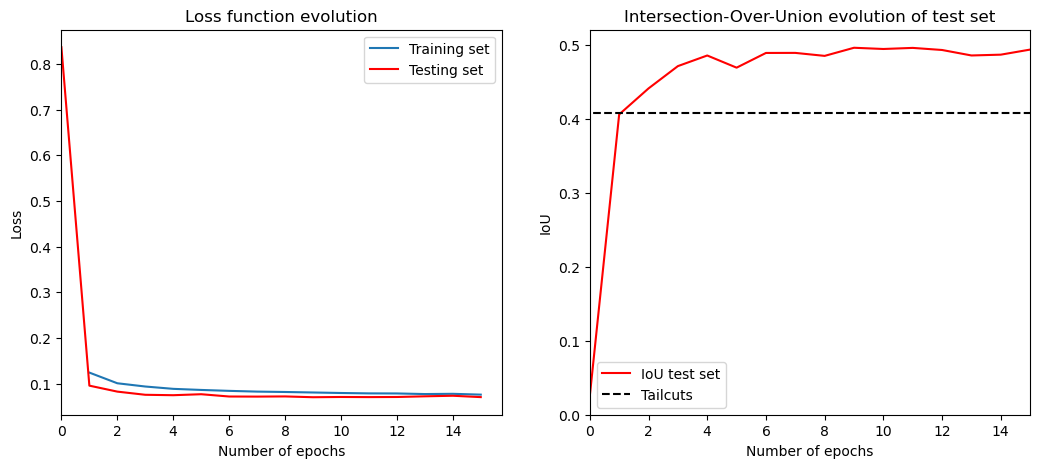

In [62]:
# Plot the fitting results as the loss function and the IoU

fig, axs = plt.subplots(1, 2, figsize=(12.5,5))

axs[0].set_title("Loss function evolution")
axs[0].plot(train_counter, train_losses, label='Training set')
axs[0].plot(test_counter, test_losses, color='red', label='Testing set')
axs[0].set_xlabel("Number of epochs")
axs[0].set_ylabel("Loss")
axs[0].set_xlim(0,)
#axs[0].set_ylim(0,)
axs[0].legend()

axs[1].set_title("Intersection-Over-Union evolution of test set")
axs[1].plot(test_counter, IOU_list, color='red', label='IoU test set')
axs[1].hlines(0.4070115627594698, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
axs[1].set_xlim(0,n_epochs)
axs[1].set_ylim(0,0.52)
axs[1].set_xlabel("Number of epochs")
axs[1].set_ylabel("IoU")
axs[1].legend()

plt.show()

In [63]:
# Copied from a notebook without star noise for comparison
IOU_without = np.array([0.01266847, 0.40483007, 0.4549535, 0.4735601, 0.48056817, 0.48420948,
                        0.48993102, 0.49143583, 0.491041, 0.49168363, 0.492882, 0.4883904,
                        0.49142233, 0.49202985, 0.49059168, 0.4922339])

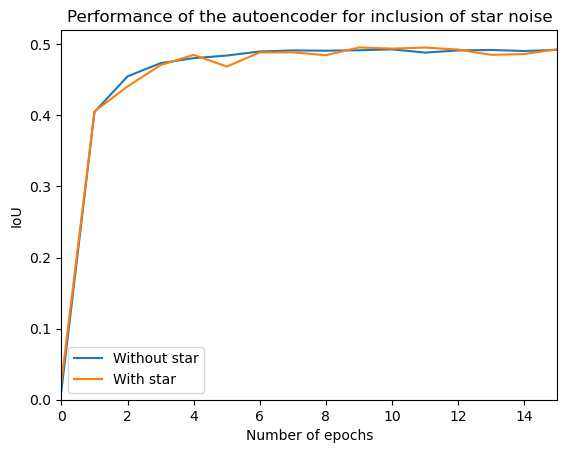

In [67]:
fig_star_noise = plt.figure()
plt.title("Performance of the autoencoder for inclusion of star noise")
plt.plot(test_counter, IOU_without, label='Without star')
plt.plot(test_counter, IOU_list, label='With star')
plt.xlim(0,n_epochs)
plt.ylim(0,0.52)
plt.xlabel("Number of epochs")
plt.ylabel("IoU")
plt.legend()
plt.show()

fig_star_noise.savefig("images/starnoise.pdf")

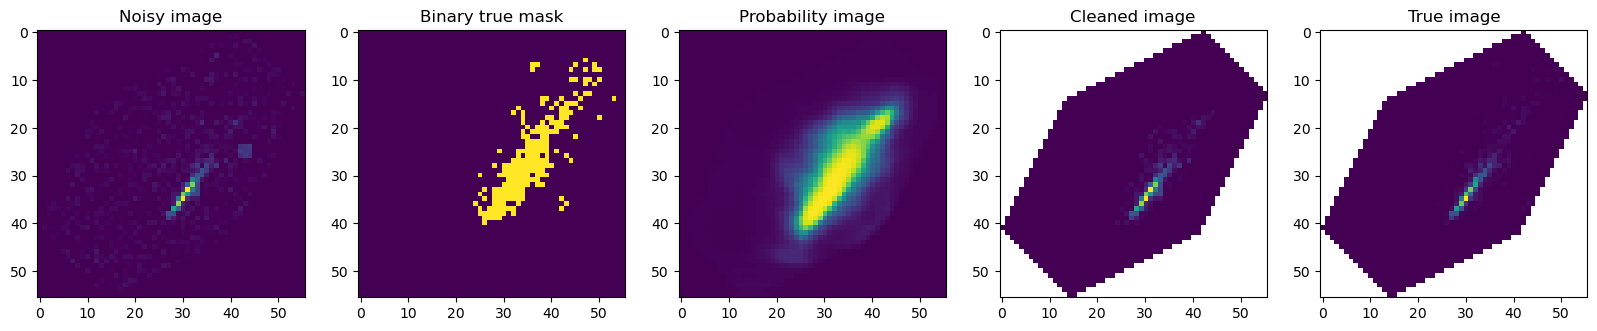

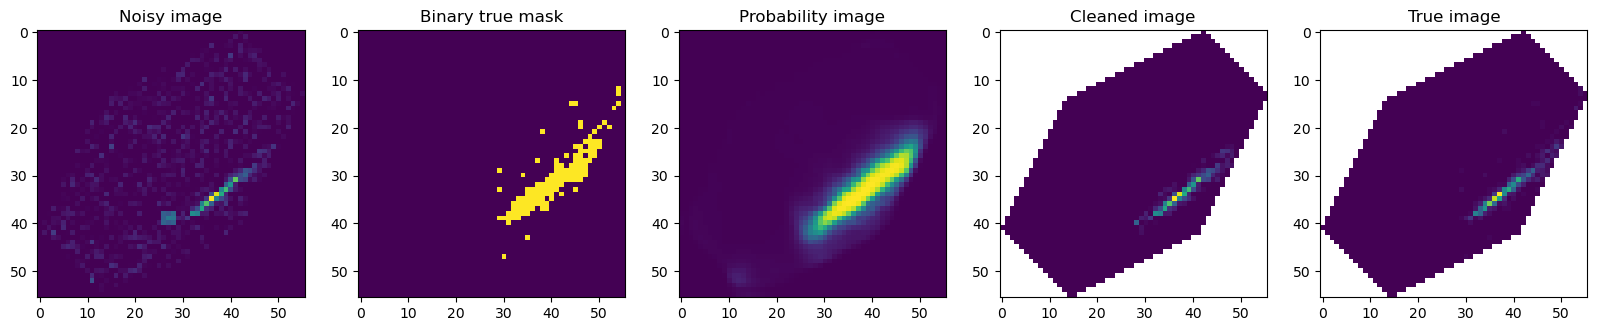

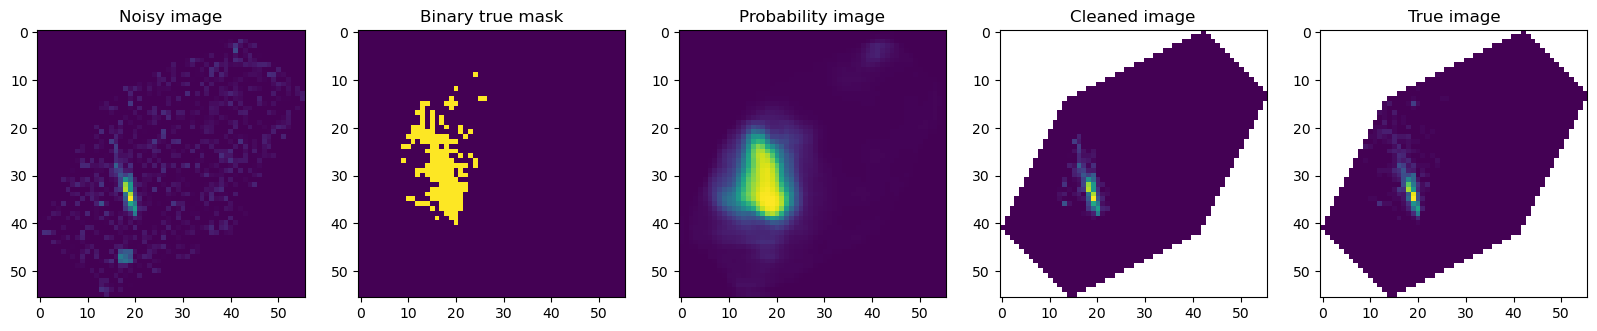

In [84]:
n_start = 40
n_im = 3

for im_i in range(n_start, n_start+n_im):
    noisy = np.zeros((2,56,56))
    noisy[0,:,:] = data_noisy_test[im_i]
    noisy[1,:,:] = data_star_test[im_i]
    noisy = torch.from_numpy(noisy).float()
    output = network(noisy)
    output = F.sigmoid(output)
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean_good[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,5,figsize=(20,10))

    axs[0].imshow(data_noisy_test_im[im_i], vmin=0)
    axs[0].set_title("Noisy image")
    
    axs[1].imshow((data_true_binary[images_high_mask])[idx_split+im_i])
    axs[1].set_title("Binary true mask")
    
    fig_clean_prob = axs[2].imshow(im_clean_prob, vmin=0)
    axs[2].set_title("Probability image")

    axs[3].imshow(im_clean_good, vmin=0)
    axs[3].set_title("Cleaned image")

    axs[4].imshow(data_true_test_im[im_i], vmin=0)
    axs[4].set_title("True image")

plt.show()    

**Compare multiple mean values**

In [ ]:
%%time

star_means = np.array([0,20,40,60,80,100])
#star_means = np.array([20,100])
n_epochs = 15
learning_rate = 0.0005

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)

train_losses_all = []
test_losses_all = []
IOU_list_all = []

for star_mean in star_means:
    print(f'/nstar noise {star_mean}')
    network = AE4()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []
    IOU_list = []

    data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_star_train, data_star_test, idx_split, data_true_test_im = add_noise(star_mean)
    
    test()
    for epoch in range(1, n_epochs + 1):
        train(epoch)
        test()
        
    data_star_train = 0
    data_star_test = 0
    data_noisy_train = 0
    data_noisy_test = 0
        
    train_losses_all.append(train_losses)
    test_losses_all.append(test_losses)
    IOU_list_all.append(IOU_list)
    
train_losses_arr = np.array(train_losses_all)
test_losses_arr = np.array(test_losses_all)
IOU_arr = np.array(IOU_list_all)    

/nstar noise 0

Test set: Avg. loss: 0.6048
IOU: 0.0056827133521437645
Training set: Avg. loss: 0.1194

Test set: Avg. loss: 0.0835
IOU: 0.42328405380249023
Training set: Avg. loss: 0.0940

Test set: Avg. loss: 0.0782
IOU: 0.4602789282798767
Training set: Avg. loss: 0.0888

Test set: Avg. loss: 0.0738
IOU: 0.4769752323627472
Training set: Avg. loss: 0.0851

Test set: Avg. loss: 0.0729
IOU: 0.47858142852783203
Training set: Avg. loss: 0.0836

Test set: Avg. loss: 0.0717
IOU: 0.4871568977832794
Training set: Avg. loss: 0.0823

Test set: Avg. loss: 0.0707
IOU: 0.4925175905227661
Training set: Avg. loss: 0.0806

Test set: Avg. loss: 0.0709
IOU: 0.49255692958831787
Training set: Avg. loss: 0.0800

Test set: Avg. loss: 0.0711
IOU: 0.4890662133693695
Training set: Avg. loss: 0.0790

Test set: Avg. loss: 0.0709
IOU: 0.48955148458480835
Training set: Avg. loss: 0.0784

Test set: Avg. loss: 0.0717
IOU: 0.4869996905326843
Training set: Avg. loss: 0.0779

Test set: Avg. loss: 0.0705
IOU: 0.4915296

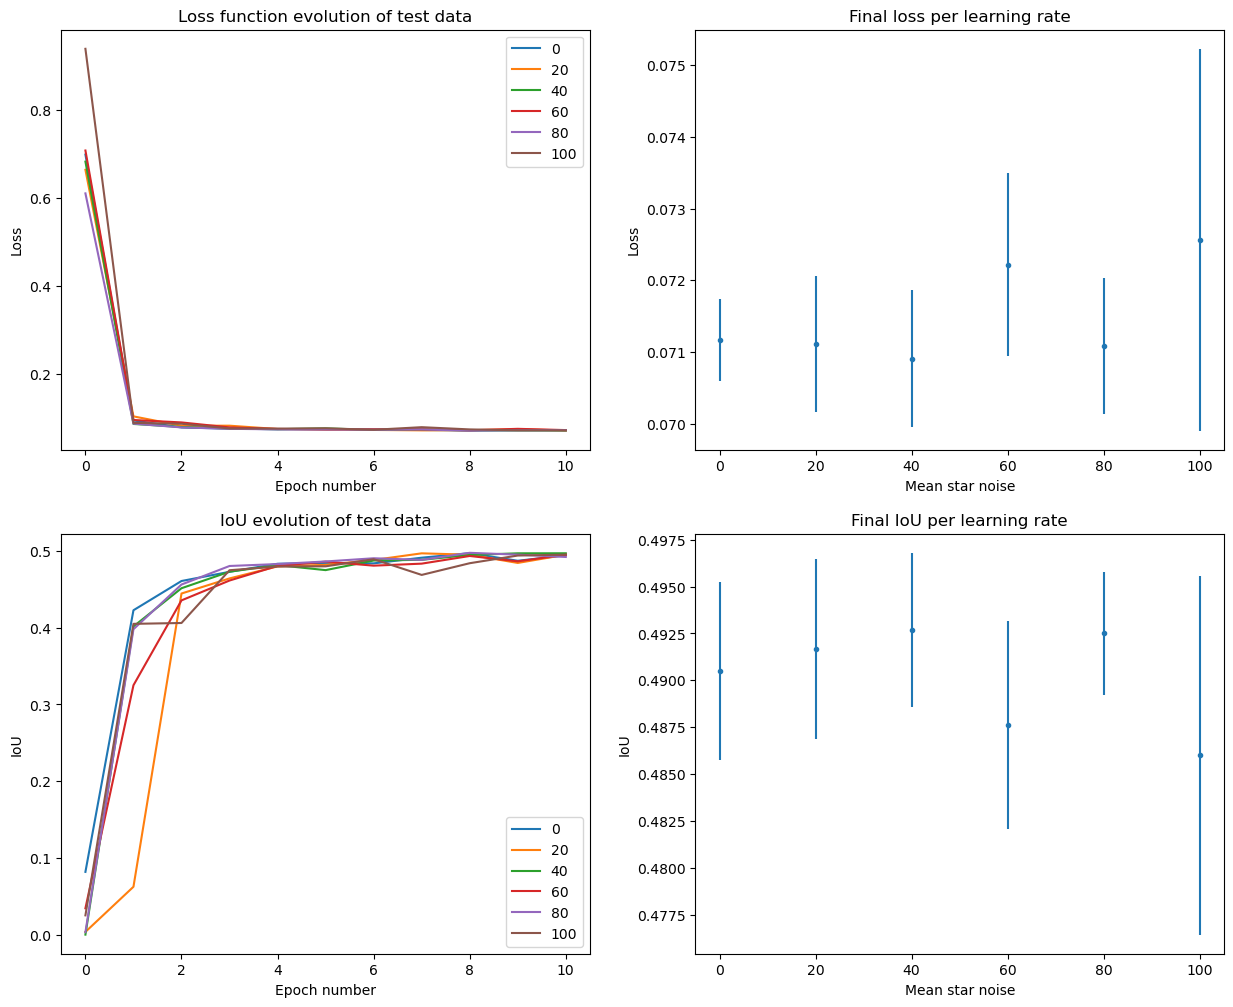

In [71]:
fig, axs = plt.subplots(2,2,figsize=(15,12))

i=0
for star_mean in star_means:
    axs[0,0].plot(np.arange(0, n_epochs+1, 1), test_losses_arr[i], label=star_mean)
    axs[1,0].plot(np.arange(0, n_epochs+1, 1), IOU_arr[i], label=star_mean)
    
    i=i+1
    
axs[0,0].legend()
axs[0,0].set_xlabel("Epoch number")
axs[0,0].set_ylabel("Loss")
axs[0,0].set_title("Loss function evolution of test data")

axs[0,1].errorbar(star_means, np.mean(test_losses_arr[:,-5:], axis=1), yerr=np.std(test_losses_arr[:, -5:], axis=1), fmt='.')
axs[0,1].set_xlabel("Mean star noise")
axs[0,1].set_ylabel("Loss")
axs[0,1].set_title("Final loss per learning rate")

axs[1,0].legend()
axs[1,0].set_xlabel("Epoch number")
axs[1,0].set_ylabel("IoU")
axs[1,0].set_title("IoU evolution of test data")

axs[1,1].errorbar(star_means, np.mean(IOU_arr[:, -5:], axis=1), yerr=np.std(IOU_arr[:, -5:], axis=1), fmt='.')
axs[1,1].set_xlabel("Mean star noise")
axs[1,1].set_ylabel("IoU")
axs[1,1].set_title("Final IoU per learning rate")

plt.show()

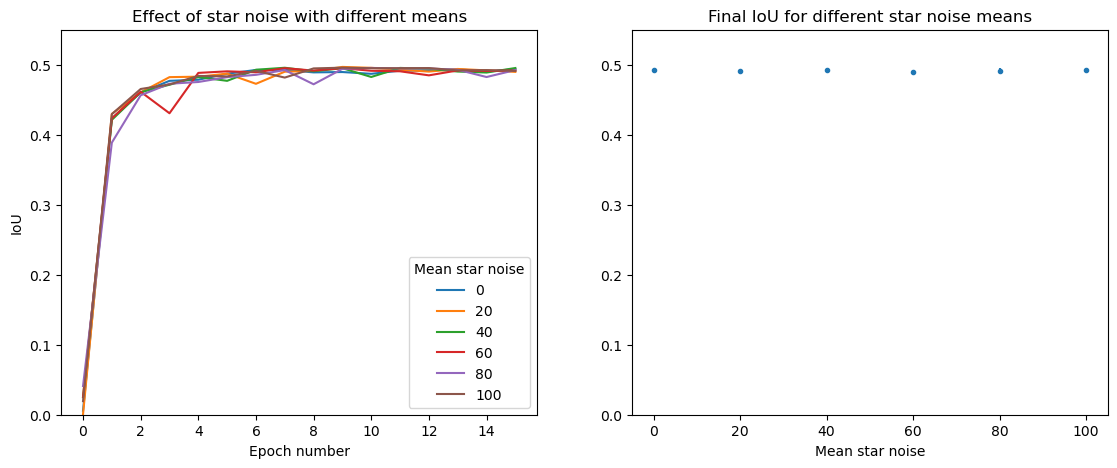

In [84]:
fig_star_noises, axs = plt.subplots(1,2,figsize=(13.5,5))

i=0
for star_mean in star_means:
    axs[0].plot(np.arange(0, n_epochs+1, 1), IOU_arr[i], label=star_mean)
    
    i=i+1

axs[0].legend(title='Mean star noise')
axs[0].set_xlabel("Epoch number")
axs[0].set_ylabel("IoU")
axs[0].set_ylim(0,0.55)
axs[0].set_title("Effect of star noise with different means")

axs[1].errorbar(star_means, np.mean(IOU_arr[:, -5:], axis=1), yerr=np.std(IOU_arr[:, -5:], axis=1), fmt='.')
axs[1].set_xlabel("Mean star noise")
#axs[1].set_ylabel("IoU")
axs[1].set_title("Final IoU for different star noise means")
axs[1].set_ylim(0,0.55)

plt.show()
fig_star_noises.savefig("images/StarNoises.pdf")